In [16]:
import pandas as pd
import pyarrow.dataset as pads
import os
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', None)

In [17]:
everything_df = pd.read_csv('everything_df.csv')
everything_df

,Unnamed: 0,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,fielding_team,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,field_x_7,field_y_7,field_x_8,field_y_8,field_x_9,field_y_9,field_x_10,field_y_10,field_x_11,field_y_11,field_x_12,field_y_12,ball_position_x,ball_position_y,ball_position_z,arm_strength_mph,as+,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability,let,cut_hold,cut_relay,optimal_action,cutoff_man,cutoff_decision,cutoff_x,cutoff_y,cut_code,cutoff_dist_to_base,baserunner_player_id
0,0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1824,CGA-1929,CGA-1592,CGA-2010,-110.8791,230.5518,94.4808,338.4810,65.4084,291.4254,35.7615,110.5899,-44.5356,100.8936,-62.0019,65.0769,95.34480,339.4440,0.000000,58.470382,115.5,10,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499,0.998179,3.118678,3.253,3.087426,cut_relay,second baseman,cut_relay,41.7405,194.3859,4.0,79.266190,CGA-1824
1,1,y1_d001_CGA_QEA,114,4231155,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0404,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1353,CGA-1824,CGA-1929,CGA-1592,-121.0008,236.3949,28.4658,327.7230,139.5966,299.0814,61.1802,61.2882,NaN,NaN,NaN,NaN,138.17340,295.9152,5.194530,56.607167,109.8,10,Home,2B,True,True,61.1802,61.2882,89.783392,139.5966,299.0814,221.583436,0.924588,0.564000,0.564,0.528029,cut_hold,second baseman,cut_hold,25.8921,137.6235,4.0,27.986775,CGA-1353
2,2,y1_d001_CGA_QEA,216,8333280,9,right field,ball acquired,QEA,CGA,top,QEA,QEA-0152,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1929,CGA-1592,CGA-1547,NaN,-119.2062,233.3106,-29.9289,274.1229,188.1207,245.4093,56.9868,46.3326,NaN,NaN,-50.5641,38.5989,188.00880,246.3627,0.000000,67.167101,109.8,10,Home,2B,True,True,56.9868,46.3326,98.766010,188.1207,245.4093,222.283963,0.853419,1.563964,1.564,1.494081,cut_relay,shortstop,cut_hold,11.6007,132.4140,6.0,12.801861,CGA-1929
3,3,y1_d002_CGA_QEA,92,3087421,7,left field,ball acquired,QEA,CGA,bottom,CGA,CGA-2074,CGA-1127,CGA-1592,CGA-1824,CGA-1198,CGA-2010,CGA-1353,CGA-1458,CGA-1547,QEA-0252,QEA-0235,QEA-0120,NaN,-200.5506,236.1000,-61.6011,276.9882,113.8962,207.5649,57.1884,47.2554,-6.3957,122.2593,-57.1140,67.5888,-201.44550,237.1629,0.000000,62.909130,94.7,10,Home,2B,True,True,57.1884,47.2554,98.131108,-200.5506,236.1000,228.305395,0.859377,2.242993,2.253,2.067900,cut_relay,shortstop,cut_relay,-55.6794,140.5182,6.0,57.296922,QEA-0252
4,4,y1_d003_CGA_QEA,92,3994106,9,right field,ball acquired,QEA,CGA,bottom,CGA,CGA-1302,CGA-1503,CGA-1592,CGA-1458,CGA-1166,CGA-2010,CGA-1824,CGA-1547,CGA-1198,QEA-0249,QEA-0365,NaN,NaN,-136.9167,241.8789,51.5217,335.9463,69.6903,327.1002,59.4930,72.1209,NaN,NaN,NaN,NaN,67.77840,325.8180,0.011808,65.544151,106.3,10,Home,2B,True,True,59.4930,72.1209,80.939068,69.6903,327.1002,211.888716,0.959689,0.564000,0.564,0.544772,cut_hold,second baseman,cut_hold,18.4110,161.4603,4.0,39.070157,QEA-0249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1515,y2_d094_QZE_RZQ,341,11657364,8,center field,ball acquired,RZQ,QZE,bottom,QZE,QZE-2449,QZE-2394,QZE-1252,QZE-1479,QZE-2357,QZE-1245,QZE-2280,QZE-1638,QZE-2217,RZQ-0310,RZQ-0275,RZQ-0231,NaN,-97.8660,261.7449,-2.0037,243.5127,118.4931,246.9180,47.1309,35.7042,1.6380,124.4088,-61.2816,60.3006,-3.23607,247.2696,-0.501801,73.069685,111.3,12,2B,Home,True,True,-61.2816,60.3006,85.974397,-2.0037,243.5127,243.520943,0.979210,1.840630

In [18]:
everything_df['cutoff_correct'] = everything_df['cutoff_decision'] == everything_df['optimal_action']

#Calculate for EV "cost"
def get_ev(row):
    if row['cutoff_decision'] == 'let':
        return row['let']
    elif row['cutoff_decision'] == 'cut_hold':
        return row['cut_hold']
    elif row['cutoff_decision'] == 'cut_relay':
        return row['cut_relay']
    else:
        return None

everything_df['ev_actual'] = everything_df.apply(get_ev, axis=1)

# Calculate EV loss based on minimum between let, cut_hold, and cut_relay
everything_df['ev_difference'] = everything_df['ev_actual'] - everything_df[
    ['let', 'cut_hold', 'cut_relay']
].min(axis=1)

# Aggregate by fielding team
team_cutoff_analysis = (
    everything_df.groupby('fielding_team')
    .agg(
        total_cutoff_plays=('cutoff_decision', 'count'),
        correct_decisions=('cutoff_correct', 'sum'),
        avg_ev_penalty=('ev_difference', 'mean')
    )
)

# Add accuracy rate
team_cutoff_analysis['accuracy_rate'] = (
    team_cutoff_analysis['correct_decisions'] / team_cutoff_analysis['total_cutoff_plays']
).round(3)

team_cutoff_analysis_over_100 = team_cutoff_analysis[team_cutoff_analysis['total_cutoff_plays'] > 100].sort_values(by='accuracy_rate', ascending=False)

team_cutoff_analysis = team_cutoff_analysis[team_cutoff_analysis['total_cutoff_plays'] > 10].sort_values(by='accuracy_rate', ascending=False) 
team_cutoff_analysis

,total_cutoff_plays,correct_decisions,avg_ev_penalty,accuracy_rate
fielding_team,,,,
ESW,13,12,0.008069,0.923
JIL,18,15,0.010377,0.833
WZR,16,13,0.047288,0.812
WJU,20,16,0.012200,0.800
IAK,20,15,0.014210,0.750
GIS,17,12,0.081965,0.706
IHI,15,10,0.017853,0.667
RZQ,315,204,0.046238,0.648
RDO,14,9,0.035689,0.643


/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_77352/2379810029.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_cutoff_analysis.reset_index(), x='fielding_team', y='accuracy_rate', palette='viridis')


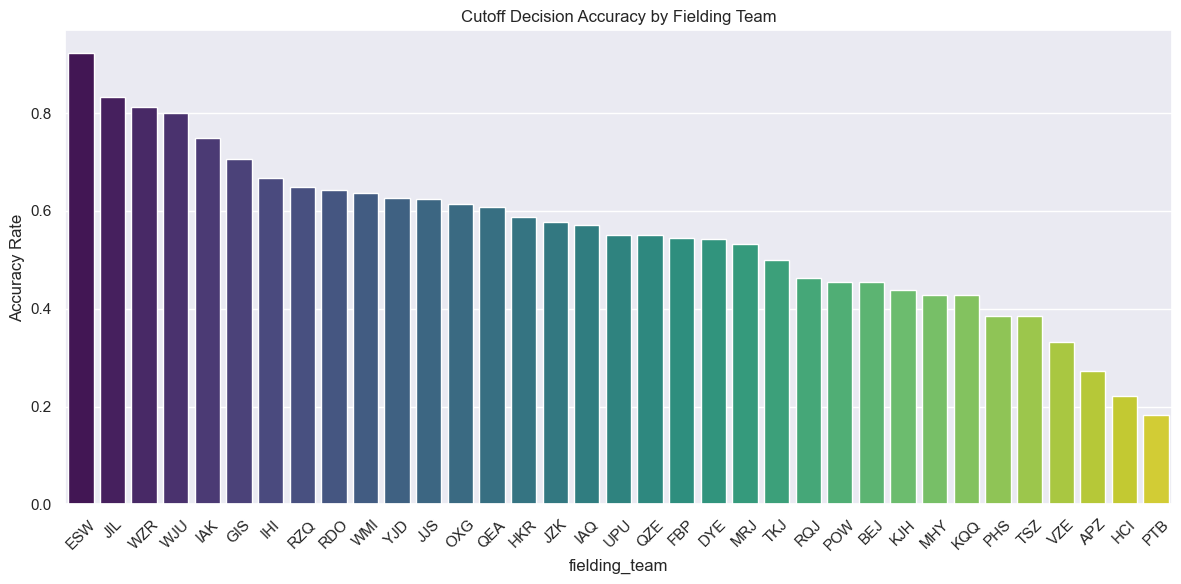

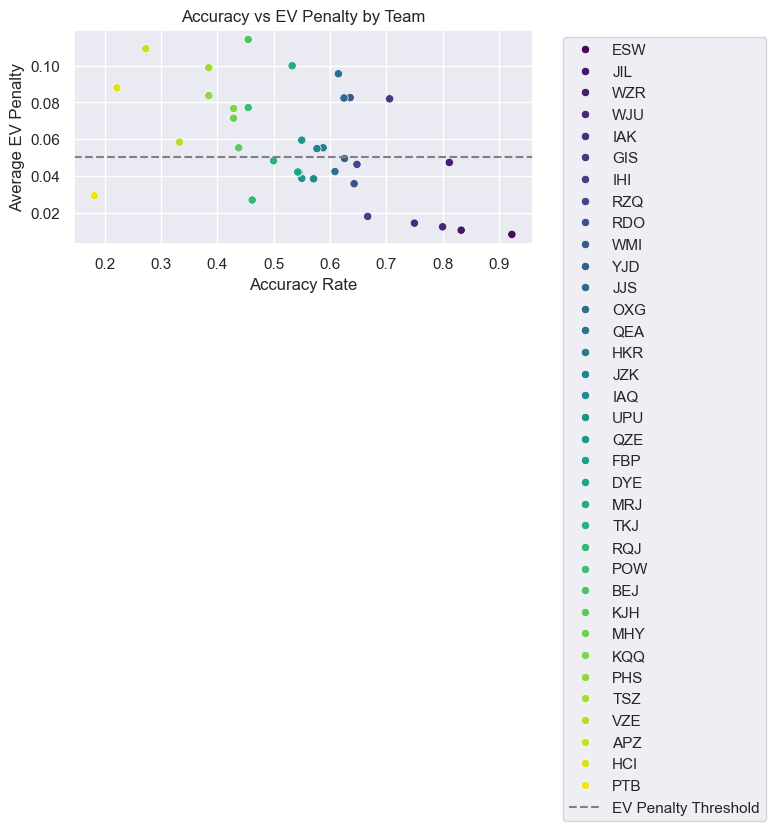

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sorted bar chart to graph cutoff accuracy per team
plt.figure(figsize=(12, 6))
sns.barplot(data=team_cutoff_analysis.reset_index(), x='fielding_team', y='accuracy_rate', palette='viridis')
plt.title('Cutoff Decision Accuracy by Fielding Team')
plt.ylabel('Accuracy Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatterplot of ccuracy vs Avg EV Penalty
# EV Threshold at 0.05, don't know what it would visually represent but potentially helpful
plt.figure(figsize=(8, 6))
sns.scatterplot(data=team_cutoff_analysis, x='accuracy_rate', y='avg_ev_penalty', hue=team_cutoff_analysis.index, palette='viridis')
plt.title('Accuracy vs EV Penalty by Team')
plt.xlabel('Accuracy Rate')
plt.ylabel('Average EV Penalty')
plt.axhline(0.05, color='gray', linestyle='--', label='EV Penalty Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
#Create extra path column
everything_df['path'] = everything_df['from_base'] + "->" + everything_df['to_base']


# Create concatenated basepath column
grouped_play = everything_df.groupby(['game_str', 'play_id', 'fielding_team'])['path'].apply(list).reset_index()
grouped_play['basepath'] = grouped_play['path'].apply(lambda x: ', '.join(x))
grouped_play = grouped_play.drop(columns = ['path'])

master_df = everything_df.merge(grouped_play, on = ['game_str', 'play_id', 'fielding_team'], how = 'left')

main_teams = master_df[(master_df['cutoff_correct'] == False) & (master_df['fielding_team'].isin(['QEA', 'RZQ', 'YJD']))]

# Pivot table for each team, cutoff_decision, optimal_action, and every average EV penalty per basepath combination
ev_penalty = main_teams.groupby(['fielding_team', 'cutoff_decision', 'optimal_action', 'basepath'])['ev_difference'].mean().reset_index().sort_values(by = 'ev_difference', ascending = False)
ev_pivoted = pd.pivot_table(ev_penalty, values = 'ev_difference', index = ['fielding_team', 'cutoff_decision', 'optimal_action'], columns = 'basepath', fill_value = 0.0).reset_index().set_index(['fielding_team', 'cutoff_decision', 'optimal_action'])
ev_pivoted

,game_str,play_id,fielding_team,path
0,y1_d001_CGA_QEA,108,QEA,"[Home->2B, Home->3B, 1B->3B, 1B->Home, 2B->Home]"
1,y1_d001_CGA_QEA,114,QEA,[Home->2B]
2,y1_d001_CGA_QEA,216,QEA,"[Home->2B, 2B->Home]"
3,y1_d002_CGA_QEA,92,CGA,"[Home->2B, 1B->3B, 2B->Home]"
4,y1_d002_CGA_QEA,99,CGA,[1B->3B]
...,...,...,...,...
794,y2_d097_YJD_RZQ,19,YJD,[1B->3B]
795,y2_d097_YJD_RZQ,53,YJD,"[Home->2B, 1B->3B, 1B->Home]"
796,y2_d097_YJD_RZQ,135,RZQ,[1B->3B]
797,y2_d097_YJD_RZQ,158,RZQ,"[Home->2B, 1B->3B, 1B->Home]"


basepath                                        1B->3B  1B->3B, 2B->Home  \
fielding_team cutoff_decision optimal_action                               
QEA           cut_hold        cut_relay       0.160915          0.181690   
                              let             0.000000          0.000000   
              cut_relay       cut_hold        0.000000          0.000000   
                              let             0.000000          0.000000   
              let             cut_hold        0.000000          0.000000   
                              cut_relay       0.000000          0.049467   
RZQ           cut_hold        cut_relay       0.120132          0.131162   
                              let             0.000000          0.000000   
              cut_relay       let             0.000000          0.000000   
              let             cut_hold        0.000000          0.000000   
                              cut_relay       0.000000          0.292615   
YJD           cut_hold        cut_relay       0.152347          0.127684   
                              let             0.000000          0.000000   
              cut_relay       cut_hold        0.000000          0.000000   
                              let             0.000000          0.000000   
              let             cut_hold        0.000000          0.000000   
                              cut_relay       0.000000          0.219277   

basepath                                      2B->Home  Home->2B  \
fielding_team cutoff_decision optimal_action                       
QEA           cut_hold        cut_relay       0.000000  0.065797   
                              let             0.172767  0.000000   
              cut_relay       cut_hold        0.000315  0.000000   
                              let             0.067338  0.000000   
              let             cut_hold        0.000000  0.000000   
                              cut_relay       0.000000  0.000000   
RZQ           cut_hold        cut_relay       0.000000  0.063561   
                              let             0.135733  0.000000   
              cut_relay       let             0.000000  0.000000   
              let             cut_hold        0.000000  0.000000   
                              cut_relay       0.000000  0.000000   
YJD           cut_hold        cut_relay       0.000000  0.068568   
                              let             0.082898  0.000000   
              cut_relay       cut_hold        0.000000  0.000000   
                              let             0.000000  0.000000   
              let             cut_hold        0.000000  0.000000   
                              cut_relay       0.000000  0.000000   

basepath                                      Home->2B, 1B->3B  \
fielding_team cutoff_decision optimal_action                     
QEA           cut_hold        cut_relay               0.120511   
                              let                     0.000000   
              cut_relay       cut_hold                0.000000   
                              let                     0.000000   
              let             cut_hold                0.000000   
                              cut_relay               0.000000   
RZQ           cut_hold        cut_relay               0.095746   
                              let                     0.000000   
              cut_relay       let                     0.000000   
              let             cut_hold                0.005506   
                              cut_relay               0.000000   
YJD           cut_hold        cut_relay               0.169525   
                              let                     0.000000   
              cut_relay       cut_hold                0.000000   
                              let                     0.000000   
              let             cut_hold                0.000000   
                              cut_relay               0.000000   

basepat

cutoff_decision,cut_hold,cut_relay,let
fielding_team,,,
QEA,0.525000,0.175000,0.300000
RZQ,0.721519,0.126582,0.151899
YJD,0.678571,0.119048,0.202381


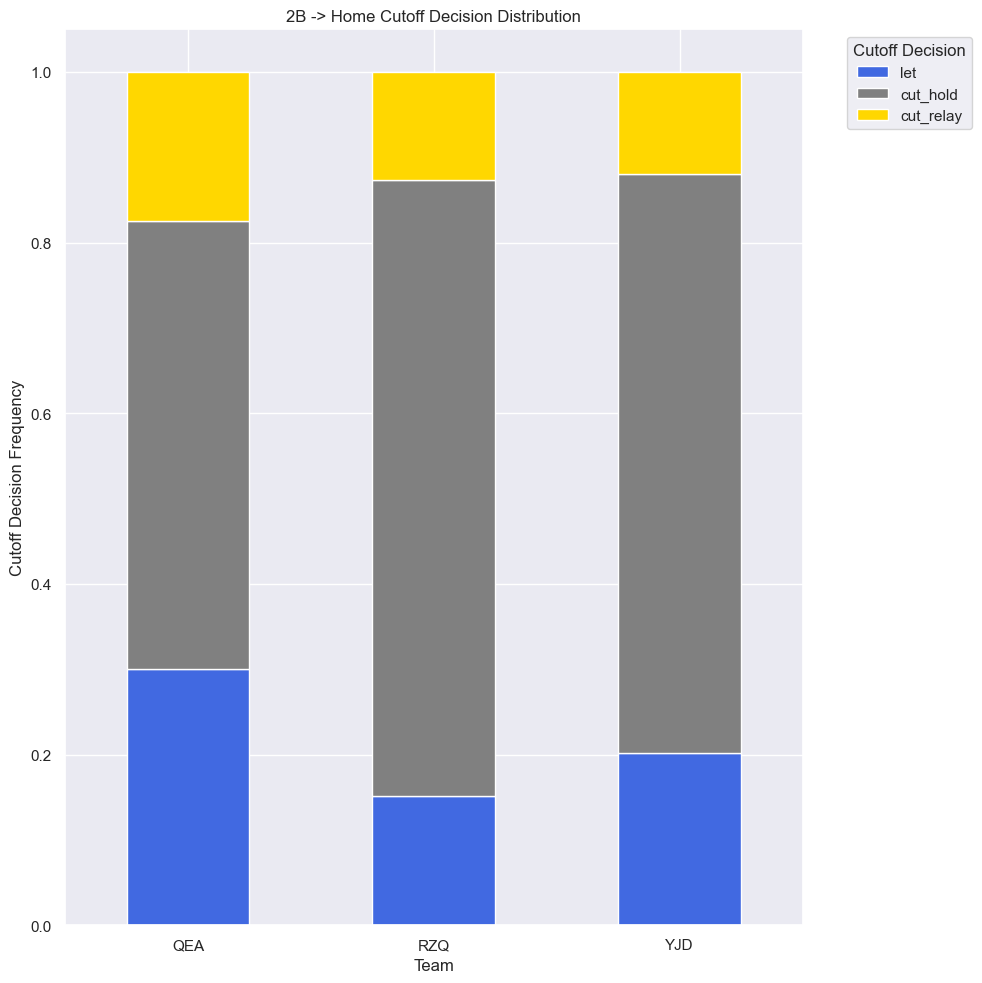

In [36]:
# Prep for stacked bar chart
stacked_decisions = (master_df[(master_df['path'] == '2B->Home') & (master_df['fielding_team'].isin(['QEA', 'RZQ', 'YJD']))]).groupby(['fielding_team', 'cutoff_decision']).size().unstack(fill_value = 0)
stacked_decisions_pct = stacked_decisions.div(stacked_decisions.sum(axis = 1), axis = 0)
display(stacked_decisions_pct)

colors = {
    'let': '#4169E1',        
    'cut_hold': '#808080',   
    'cut_relay': '#FFD700'   
}

used_decisions = [col for col in ['let', 'cut_hold', 'cut_relay'] if col in stacked_decisions_pct.columns]

# Stacked bar chart for used_decisions
ax = stacked_decisions_pct[used_decisions].plot(
    kind = 'bar', 
    stacked = True,
    figsize = (10, 10),
    color = [colors[decision] for decision in used_decisions]
)

#Plot
plt.title('2B -> Home Cutoff Decision Distribution')
plt.xlabel('Team')
plt.ylabel('Cutoff Decision Frequency')
plt.legend(title = 'Cutoff Decision', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


In [ ]:
# Similar process for previous larger pivot table, without specifiying cutoff decision, optimal action, or multiple paths in a play
# Only a pivot table for individual paths' EV penalty for all fielding teams
basepaths_grouped = everything_df.groupby(['fielding_team', 'path'])['ev_difference'].mean().reset_index()
pivoted = basepaths_grouped.pivot_table(
    index='fielding_team',
    columns='path',
    values='ev_difference',
    aggfunc='mean'
).fillna(0)

pivoted

path,1B->3B,1B->Home,2B->Home,Home->2B,Home->3B
fielding_team,,,,,
ACN,0.002003,0.000000,0.007769,0.031872,0.000000
AKX,0.002402,0.000000,0.004340,0.001297,0.000000
ALA,0.034939,0.000000,0.000000,0.034939,0.000000
APZ,0.164388,0.000000,0.021848,0.101665,0.299486
BEJ,0.115593,0.000000,0.093906,0.139737,0.000000
...,...,...,...,...,...
XAX,0.047912,0.000000,0.000000,0.055026,0.000000
XFE,0.005412,0.000000,0.026906,0.021144,0.000000
XLB,0.062311,0.000000,0.011087,0.047648,0.000000


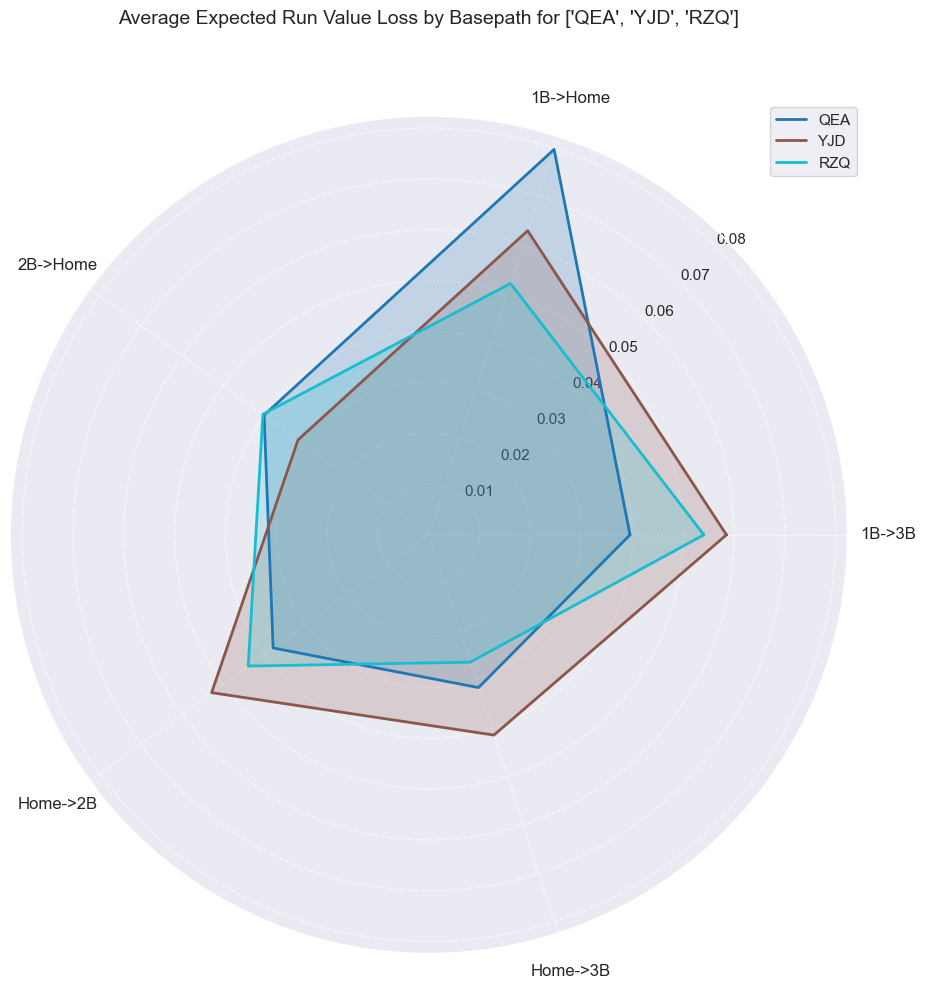

In [51]:
#Radar/Spider Plot
import seaborn as sns 

def plot_team_radar(df, teams_to_plot):
    labels = df.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    colors = plt.cm.tab10(np.linspace(0, 1, len(teams_to_plot)))
    
    for i, team in enumerate(teams_to_plot):
        values = df.loc[team].tolist()
        # Doesn't work if you don't add the first value to the end of the list of values
        values += values[:1]
        ax.plot(angles, values, label=team, color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(pad = 16)
    ax.set_title(f"Average Expected Run Value Loss by Basepath for {teams_to_plot}", fontsize=14, y=1.1)
    ax.set_rlabel_position(45)
    ax.grid(True, linestyle='dotted')
    ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02))
    plt.tight_layout()
    plt.show()

plot_team_radar(pivoted, teams_to_plot=['QEA', 'YJD', 'RZQ'])

In [56]:
radar_path_prep = everything_df.groupby(['fielding_team', 'path']).agg(
    total_cutoff_plays=('cutoff_decision', 'count'),
    correct_decisions=('cutoff_correct', 'sum'),
    avg_ev_penalty=('ev_difference', 'mean')
).reset_index()

radar_path_prep['accuracy'] = radar_path_prep['correct_decisions'] / radar_path_prep['total_cutoff_plays']

main_teams_by_path = radar_path_prep[radar_path_prep['fielding_team'].isin(['QEA', 'RZQ', 'YJD'])]
main_path_pivot = pd.pivot_table(main_teams_by_path, index = 'fielding_team', columns = 'path', values = 'accuracy')
main_path_pivot

path,1B->3B,1B->Home,2B->Home,Home->2B,Home->3B
fielding_team,,,,,
QEA,0.693878,0.538462,0.550000,0.588235,0.666667
RZQ,0.598039,0.478261,0.759494,0.646465,0.666667
YJD,0.636364,0.458333,0.714286,0.589474,0.500000


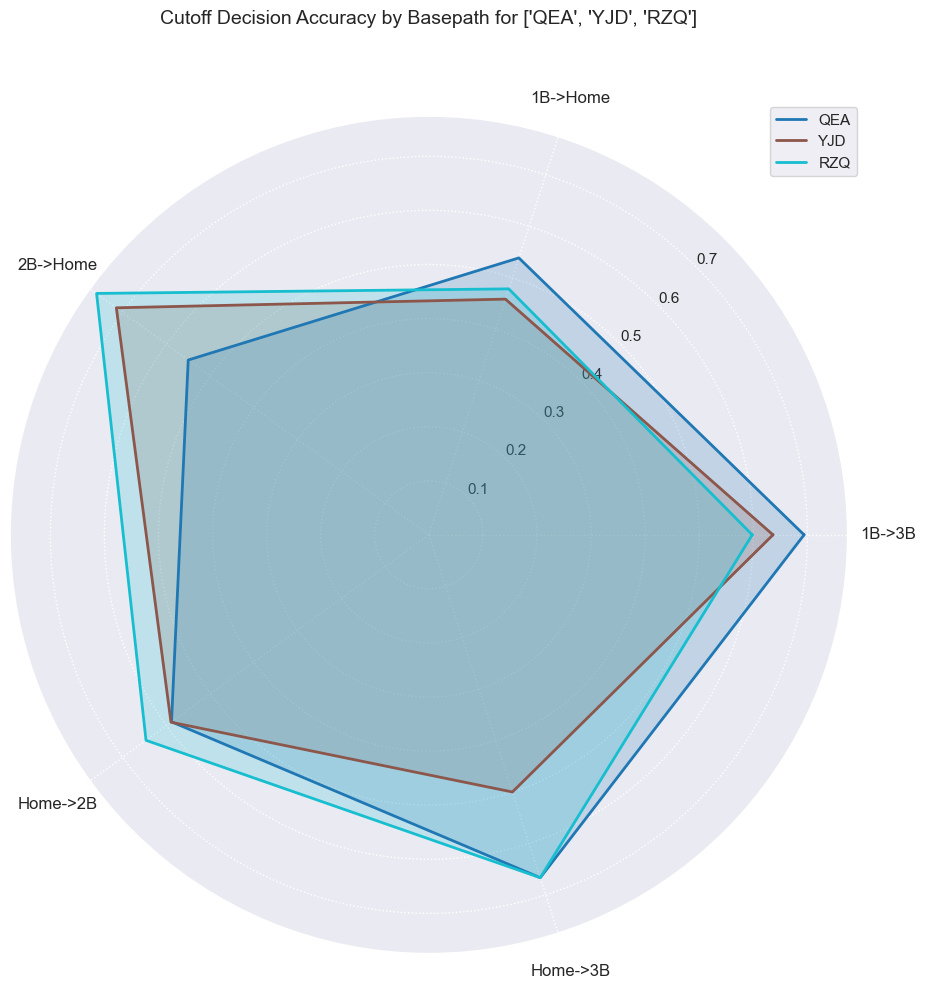

In [58]:
#Radar/Spider Plot for accuracy

def plot_team_radar(df, teams_to_plot):
    labels = df.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    colors = plt.cm.tab10(np.linspace(0, 1, len(teams_to_plot)))
    
    for i, team in enumerate(teams_to_plot):
        values = df.loc[team].tolist()
        # Doesn't work if you don't add the first value to the end of the list of values
        values += values[:1]
        ax.plot(angles, values, label=team, color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(pad = 16)
    ax.set_title(f"Cutoff Decision Accuracy by Basepath for {teams_to_plot}", fontsize=14, y=1.1)
    ax.set_rlabel_position(45)
    ax.grid(True, linestyle='dotted')
    ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1.02))
    plt.tight_layout()
    plt.show()

plot_team_radar(main_path_pivot, teams_to_plot=['QEA', 'YJD', 'RZQ'])